In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
df = pd.read_pickle("C:/Users/veglia/Downloads/CIY.51.I1.pkl")
arr=df.to_numpy()

In [3]:
bpms_x = [i for i in list(df)[1:] if i[-5] == 'X']
bpms_y = [i for i in list(df)[1:] if i[-5] == 'Y']

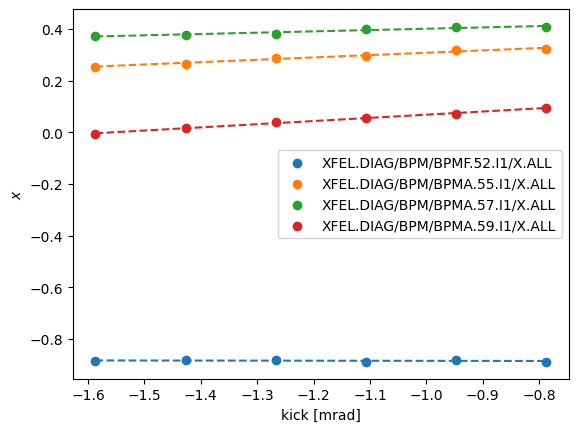

In [4]:
fitx={}
for col in bpms_x:
    plt.scatter(arr[:,0],df[col],label=col)
    coef = np.polyfit(arr[:,0], df[col], 1)
    poly1d_fn = np.poly1d(coef)
    plt.plot(arr[:,0], poly1d_fn(arr[:,0]), '--')
    fitx[col]=coef
plt.xlabel('kick [mrad]')
plt.ylabel('$x$')
plt.legend()

In [5]:
fitx

{'XFEL.DIAG/BPM/BPMF.52.I1/X.ALL': array([-0.00252684, -0.88734488]),
 'XFEL.DIAG/BPM/BPMA.55.I1/X.ALL': array([0.0907591, 0.3986084]),
 'XFEL.DIAG/BPM/BPMA.57.I1/X.ALL': array([0.05097236, 0.45179256]),
 'XFEL.DIAG/BPM/BPMA.59.I1/X.ALL': array([0.12261595, 0.1906501 ])}

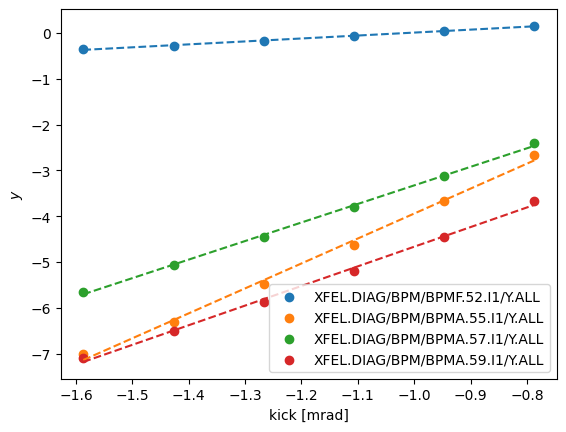

In [6]:
fit={}
for col in bpms_y:
    plt.scatter(arr[:,0],df[col],label=col)
    coef = np.polyfit(arr[:,0], df[col], 1)
    poly1d_fn = np.poly1d(coef)
    plt.plot(arr[:,0], poly1d_fn(arr[:,0]), '--')
    fit[col]=coef
plt.xlabel('kick [mrad]')
plt.ylabel('$y$')
plt.legend()


In [7]:
fit

{'XFEL.DIAG/BPM/BPMF.52.I1/Y.ALL': array([0.64255267, 0.64877606]),
 'XFEL.DIAG/BPM/BPMA.55.I1/Y.ALL': array([5.44356718, 1.50063609]),
 'XFEL.DIAG/BPM/BPMA.57.I1/Y.ALL': array([4.04765936, 0.71945375]),
 'XFEL.DIAG/BPM/BPMA.59.I1/Y.ALL': array([ 4.28240441, -0.38401666])}

In [8]:
import sys
#sys.path.append(ocelot_dir)
sys.path.insert(1, "../")

In [9]:
from s2e_sections.sections import *
from ocelot.utils.section_track import *
from ocelot.gui.accelerator import *
import time
from ocelot.common.globals import *
from ocelot import *

initializing ocelot...


In [10]:
sections = [A1, AH1, LH]

In [11]:
tws0 = Twiss()
tws0.E = 0.005
tws0.beta_x  =  0.2865426867699372
tws0.beta_y  =  0.2865426867699381
tws0.alpha_x = -0.8390696483216487
tws0.alpha_y = -0.8390696483216522

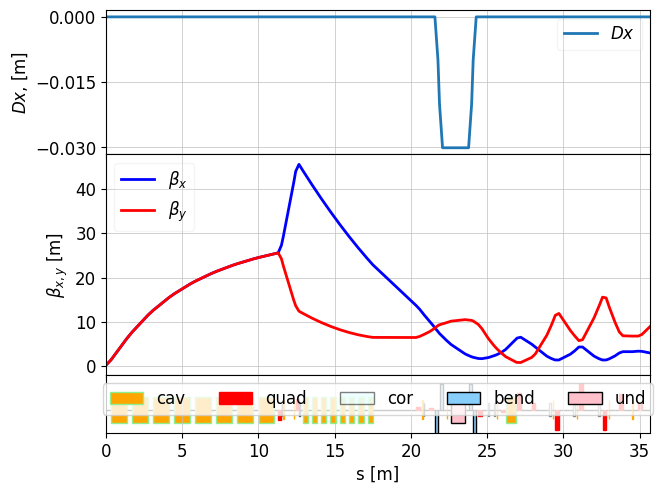

In [12]:
section_lat = SectionLattice(sequence=sections, tws0=tws0)
# plot twiss parameters
method = {'global': TransferMap}
lat = MagneticLattice(section_lat.elem_seq, method=method)
plot_opt_func(lat, section_lat.tws)
plt.show()

In [15]:
B, R, T = lat.transfer_maps(start=i1.ciy_51_i1, stop=i1.bpmf_52_i1, energy=130e-3)
r34= R[2,3]

In [16]:
r34

np.float64(0.6045)

In [17]:
fit
r34s_measured = [v for (v, _) in fit.values()]

In [18]:
bpms = [i1.bpmf_52_i1,i1.bpma_55_i1,i1.bpma_57_i1,i1.bpma_59_i1]
for bpm in bpms:
    B, R, T = lat.transfer_maps(start=i1.ciy_51_i1, stop=bpm, energy=130e-3)
    r34= R[2,3]
    print(r34)

0.6045
7.1948266491573785
5.027725316296436
5.849491643721082


In [19]:
r34s_measured 

[np.float64(0.642552667348941),
 np.float64(5.443567183418967),
 np.float64(4.047659356883097),
 np.float64(4.282404405190961)]

In [22]:
from scipy.optimize import fmin
def match_matrix(lat, start, stops, target_r34s, quads):
    def error_func(x):
        for i in range(len(quads)):
            if quads[i].__class__ == Quadrupole:
                quads[i].k1 = x[i]
        r34s = []
        for stop in stops:
            B, R, T = lat.transfer_maps(start=start, stop=stop, energy=130e-3)
            r34 = R[2,3]
            r34s.append(r34)
        
        err = (np.linalg.norm(np.array(r34s) - target_r34s)**2).sum()
        return err

    x = [0.0] * len(quads)

    for i, quad in enumerate(quads):
        if quad.__class__ != Quadrupole:
            raise ValueError("Nope")
        x[i] = quad.k1

    print("initial value: x = ", x)

    return fmin(error_func, x, xtol=1e-8, maxiter=20000, maxfun=20000)

In [23]:
i1.bpma_57_i1,i1.bpma_59_i1
i1.qi_54_i1,i1.qi_55_i1

(<Quadrupole: name=QI.54.I1 at 0x1b159ec4fd0>,
 <Quadrupole: name=QI.55.I1 at 0x1b159ec5060>)

In [27]:
match_matrix(lat, start=i1.ciy_51_i1, stops=[i1.bpma_55_i1], quads=[i1.qi_53_i1] , target_r34s=r34s_measured[1])
match_matrix(lat, start=i1.ciy_51_i1, stops=[i1.bpma_57_i1], quads=[i1.qi_54_i1] , target_r34s=r34s_measured[2])
match_matrix(lat, start=i1.ciy_51_i1, stops=[i1.bpma_59_i1], quads=[i1.qi_55_i1] , target_r34s=r34s_measured[3])

initial value: x =  [np.float64(0.6245916941394521)]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 23
         Function evaluations: 46
initial value: x =  [0.7943661063020614]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 28
         Function evaluations: 56
initial value: x =  [-2.6383360780016827]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 50


array([-2.68814515])

In [28]:
bpms = [i1.bpmf_52_i1,i1.bpma_55_i1,i1.bpma_57_i1,i1.bpma_59_i1]
for bpm in bpms:
    B, R, T = lat.transfer_maps(start=i1.ciy_51_i1, stop=bpm, energy=130e-3)
    r34_ocelot= R[2,3]
    print(f'{r34_ocelot=}')

r34_ocelot=np.float64(0.6045)
r34_ocelot=np.float64(5.847585312108792)
r34_ocelot=np.float64(3.9542053977506937)
r34_ocelot=np.float64(4.282404456795665)


In [29]:
for i in r34s_measured:  
    print('r34s_measured=',i)

r34s_measured= 0.642552667348941
r34s_measured= 5.443567183418967
r34s_measured= 4.047659356883097
r34s_measured= 4.282404405190961


In [30]:
for quad in [i1.qi_53_i1,i1.qi_54_i1,i1.qi_55_i1]:
    print(quad.k1)

0.6245916866937389
1.2085868596478924
-2.688145144481293


In [13]:
# bpms = [i1.bpmf_52_i1,i1.bpma_55_i1,i1.bpma_57_i1,i1.bpma_59_i1]
screens = [i1.otrc_55_i1, i1.otrc_56_i1, i1.otrc_58_i1, i1.otrc_59_i1]
i1.tdsa_52_i1.l = 0.7 / 2
for screen in screens:
    B, R, T = lat.transfer_maps(start=i1.tds_start, stop=screen, energy=130e-3)
    r34_screen= R[2,3]
    print(f'{screen.id}, R34 = {r34_screen}')

OTRC.55.I1, R34 = 3.1132530628257897
OTRC.56.I1, R34 = 3.3392771683550335
OTRC.58.I1, R34 = 3.7219997706466996
OTRC.59.I1, R34 = 3.415933315797279
